In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from collections import Counter
from datetime import datetime, timedelta
from sklearn import metrics
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn import ensemble
import sklearn.metrics
import time
from datetime import datetime

%matplotlib inline                                
#no need to do plt.show()

In [3]:
train = pd.read_csv('./train.csv',parse_dates=['date'])
test = pd.read_csv('./test.csv',parse_dates=['date'],index_col = 0)
print( ' train shape:{}, columns:{} '.format(train.shape,train.columns))
print( ' test shape:{}, columns:{}'.format(test.shape,test.columns))

print(train['date'].head())
print(train.columns)
train.head()

 train shape:(14006, 3), columns:Index(['id', 'date', 'speed'], dtype='object') 
 test shape:(3504, 1), columns:Index(['date'], dtype='object')
0   2017-01-01 00:00:00
1   2017-01-01 01:00:00
2   2017-01-01 02:00:00
3   2017-01-01 03:00:00
4   2017-01-01 04:00:00
Name: date, dtype: datetime64[ns]
Index(['id', 'date', 'speed'], dtype='object')


,id,date,speed
0,0,2017-01-01 00:00:00,43.002930
1,1,2017-01-01 01:00:00,46.118696
2,2,2017-01-01 02:00:00,44.294158
3,3,2017-01-01 03:00:00,41.067468
4,4,2017-01-01 04:00:00,46.448653


In [4]:
weather = pd.read_csv('./weather.csv', parse_dates=['Time'])
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day

print(weather.head())

        Time Weather  Wind  year  month  day
0 2018-01-01      多云     8  2018      1    1
1 2018-01-02      多云     8  2018      1    2
2 2018-01-03   多云~小雨     8  2018      1    3
3 2018-01-04      小雨     8  2018      1    4
4 2018-01-05    阴~小雨     0  2018      1    5


In [5]:
weather1=weather[['year','month','day','Wind']]

In [6]:
print(weather1.head())

   year  month  day  Wind
0  2018      1    1     8
1  2018      1    2     8
2  2018      1    3     8
3  2018      1    4     8
4  2018      1    5     0


In [17]:
###处理特征


for df in (train,test): 
    df['year']  = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day']   = df['date'].dt.day
    df['hr']    = df['date'].dt.hour
    df["weekdayth"] = df['date'].dt.weekday
    df["weekofyear"] = df['date'].dt.isocalendar().week.astype("int")
    df["season"] = df['date'].dt.quarter.fillna(0).astype("int")
    df["dayofyear"] = df['date'].dt.dayofyear
    
    
# for df in (train,test):
#     df['y/n-weekday'] = np.nan 
#     df.loc[(df.weekdayth>=5),'y/n-weekday']=int(1)  #周六周天为1
#     df.loc[(df.weekdayth<=4),'y/n-weekday']=int(0)  #工作日为0
#  工作日/周末   
weekday_dict = {
    0: 0, 1: 0, 2: 0,
    3: 0, 4: 0,
    5: 1, 
    6: 1,}

for df in (train,test):
    df['y/n-weekday']=df['weekdayth'].map(weekday_dict)
    
#时 转 白天黑夜早晚高峰      
for df in (train,test):
    df['hr-categori'] = np.nan #创建一个空字段，选择一个内容进行占位，不影响后面数据的插入
    df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr <= 9)&(df.hr >= 7), 'hr-categori'] = 3   #工作日的早高峰7-9点
    df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr <= 19)&(df.hr >= 17), 'hr-categori'] = 3  #工作日的晚高峰17-19点
    
    df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr >= 0)&(df.hr < 7), 'hr-categori'] = 0
    df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr > 9)&(df.hr < 17), 'hr-categori'] = 1
    df.loc[(df.weekdayth <= 4)&(df.weekdayth >= 0)&(df.hr >19)&(df.hr <= 24), 'hr-categori'] = 2

    df.loc[(df.weekdayth >= 5)&(df.hr < 19)&(df.hr > 7), 'hr-categori'] = 4                      #周末的白天
    df.loc[(df.weekdayth >= 5)&(df.hr <= 7)|(df.hr >= 19), 'hr-categori'] = 5                    #周末的晚上


public_vacation_list = [
    '20180101', '20180216','20180217','20180219','20180330','20180331','20180402','20180405',
    '20180501','20180522','20180618','20180702','20180925','20181001','20181017','20181225','20181226',
    '20170102','20170128','20170130','20170131','20170404','20170414','20170415','20170417','20170501',
    '20170503','20170530','20170701','20171002','20171005','20171028','20171225','20171226'
] 
for df in (train,test):
    df['only-ymd'] = df['date'].apply(lambda x: x.strftime('%Y%m%d'))
    df['y/n-holiday'] = df['only-ymd'].apply(lambda x: 1 if x in public_vacation_list else 0)

#加载天气
train = pd.merge(train, weather1, on = ['year','month', 'day'], how = 'left')
test = pd.merge(test, weather1, on = ['year','month', 'day'], how = 'left')

#周123很像-0，周四五-1，周天-2，周天-3
weekday_dict = {
    0: 0, 1: 0, 2: 0,
    3: 1, 4: 1,
    5: 2, 
    6: 3,}

for df in (train,test):
    df['weekdaythclass']=df['weekdayth'].map(weekday_dict)


train

df_train = train.drop(columns= ['only-ymd','date','id'], axis= 1).copy()
df_test = test.drop(columns= ['only-ymd','date'], axis= 1).copy()


wind_train = pd.get_dummies(df_train['Wind'], prefix='w', prefix_sep='_')
wind_test = pd.get_dummies(df_test['Wind'], prefix='w', prefix_sep='_') 

df_train.drop(['Wind'],axis = 1)
df_test.drop(['Wind'],axis = 1)

df_train = pd.concat([df_train,wind_train], axis=1)

df_test = pd.concat([df_test,wind_test], axis=1)


ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:49988)
Traceback (most recent call last):
  File "/usr/local/Cellar/apache-spark/3.0.1/libexec/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/Cellar/apache-spark/3.0.1/libexec/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:49988)
Traceback (most recent call last):
  File "/usr/local/Cellar/apache-spark/3.0.1/libexec/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError:

KeyError: 'Wind'

In [8]:
df_train.corr()['speed']   

speed             1.000000
year              0.015102
month            -0.028827
day              -0.019485
hr               -0.390044
weekdayth         0.115887
weekofyear       -0.026907
season           -0.022967
dayofyear        -0.030255
y/n-weekday       0.144478
hr-categori      -0.017517
y/n-holiday       0.055386
Wind              0.030279
weekdaythclass    0.151015
w_0              -0.020286
w_2               0.007465
w_3              -0.005268
w_5              -0.002846
w_6              -0.008172
w_7               0.007959
w_8               0.020017
w_10              0.014795
w_12              0.024941
w_14              0.027469
w_16              0.016915
Name: speed, dtype: float64

In [10]:
df_train.drop(columns= ['weekofyear','dayofyear','hr-categori','season','Wind'], axis= 1)

,speed,year,month,day,hr,weekdayth,y/n-weekday,y/n-holiday,weekdaythclass,w_0,w_2,w_3,w_5,w_6,w_7,w_8,w_10,w_12,w_14,w_16
0,43.002930,2017,1,1,0,6,1,0,3,0,0,0,0,1,0,0,0,0,0,0
1,46.118696,2017,1,1,1,6,1,0,3,0,0,0,0,1,0,0,0,0,0,0
2,44.294158,2017,1,1,2,6,1,0,3,0,0,0,0,1,0,0,0,0,0,0
3,41.067468,2017,1,1,3,6,1,0,3,0,0,0,0,1,0,0,0,0,0,0
4,46.448653,2017,1,1,4,6,1,0,3,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14001,19.865269,2018,12,31,12,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
14002,17.820375,2018,12,31,15,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
14003,12.501851,2018,12,31,16,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
14004,15.979319,2018,12,31,18,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [15]:
####不需要编码了
from sklearn.model_selection import train_test_split

Train, Valid = train_test_split(df_train, test_size = 0.01)

X_train = Train.drop(['speed'], axis=1)     

Y_train = Train["speed"]                    

X_valid = Valid.drop(['speed'], axis=1)       

Y_valid = Valid["speed"]                      


Y_valid = Y_valid.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

dtrain = xgb.DMatrix(X_train, label=Y_train)    
dvalid = xgb.DMatrix(X_valid, label=Y_valid)      

dtest = xgb.DMatrix(df_test) 


xgb_pars = {
    #'nthread':            4,  
    'objective':          'reg:squarederror',
    'learning_rate':      0.01,
    'min_child_weight':   1,  
# 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
#这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
    'max_depth':          70,  #构建树的深度，越大越容易过拟合
    'subsample':          0.7,# 随机采样训练样本 训练实例的子采样比
    'colsample_bytree':   0.8,# 生成树时进行的列采样 
    'colsample_bylevel':  1,
    'verbosity':             0,
    'reg_alpha':          0.1,
    'gamma':              0.1,# 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
    'reg_lambda':         2,# 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
}

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

model = xgb.train(xgb_pars, dtrain, 3000, watchlist, early_stopping_rounds=5,
      maximize=False, verbose_eval=1)

print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:34.68600	valid-rmse:33.86704
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[1]	train-rmse:34.35021	valid-rmse:33.53906
[2]	train-rmse:34.01799	valid-rmse:33.21416
[3]	train-rmse:33.68910	valid-rmse:32.89187
[4]	train-rmse:33.36334	valid-rmse:32.57245
[5]	train-rmse:33.04218	valid-rmse:32.25755
[6]	train-rmse:32.72260	valid-rmse:31.94483
[7]	train-rmse:32.40657	valid-rmse:31.63589
[8]	train-rmse:32.09909	valid-rmse:31.33583
[9]	train-rmse:31.78940	valid-rmse:31.03391
[10]	train-rmse:31.48293	valid-rmse:30.73436
[11]	train-rmse:31.17905	valid-rmse:30.43718
[12]	train-rmse:30.87915	valid-rmse:30.14524
[13]	train-rmse:30.58222	valid-rmse:29.85510
[14]	train-rmse:30.28807	valid-rmse:29.56748
[15]	train-rmse:29.99674	valid-rmse:29.28262
[16]	train-rmse:29.70872	valid-rmse:29.00097
[17]	train-rmse:29.42634	valid-rmse:28.72498
[18]	train-rmse:29.14388	valid-rmse:28.44993
[19]	train-

[180]	train-rmse:7.11677	valid-rmse:7.21884
[181]	train-rmse:7.06234	valid-rmse:7.17097
[182]	train-rmse:7.00859	valid-rmse:7.12567
[183]	train-rmse:6.95864	valid-rmse:7.08213
[184]	train-rmse:6.90723	valid-rmse:7.03704
[185]	train-rmse:6.85623	valid-rmse:6.98980
[186]	train-rmse:6.80488	valid-rmse:6.94345
[187]	train-rmse:6.75394	valid-rmse:6.89851
[188]	train-rmse:6.70509	valid-rmse:6.85648
[189]	train-rmse:6.65492	valid-rmse:6.81073
[190]	train-rmse:6.60540	valid-rmse:6.76797
[191]	train-rmse:6.55743	valid-rmse:6.72703
[192]	train-rmse:6.50797	valid-rmse:6.68223
[193]	train-rmse:6.45980	valid-rmse:6.64147
[194]	train-rmse:6.41503	valid-rmse:6.60118
[195]	train-rmse:6.37022	valid-rmse:6.56215
[196]	train-rmse:6.32579	valid-rmse:6.52406
[197]	train-rmse:6.28184	valid-rmse:6.48547
[198]	train-rmse:6.23667	valid-rmse:6.44834
[199]	train-rmse:6.19952	valid-rmse:6.41517
[200]	train-rmse:6.15467	valid-rmse:6.37646
[201]	train-rmse:6.11349	valid-rmse:6.34391
[202]	train-rmse:6.06979	valid-r

[367]	train-rmse:2.55585	valid-rmse:3.84007
[368]	train-rmse:2.54558	valid-rmse:3.83728
[369]	train-rmse:2.53493	valid-rmse:3.83588
[370]	train-rmse:2.52411	valid-rmse:3.83208
[371]	train-rmse:2.51478	valid-rmse:3.82977
[372]	train-rmse:2.50537	valid-rmse:3.82893
[373]	train-rmse:2.49853	valid-rmse:3.82554
[374]	train-rmse:2.48811	valid-rmse:3.82258
[375]	train-rmse:2.47815	valid-rmse:3.81874
[376]	train-rmse:2.46836	valid-rmse:3.81467
[377]	train-rmse:2.45857	valid-rmse:3.81034
[378]	train-rmse:2.44937	valid-rmse:3.80725
[379]	train-rmse:2.43998	valid-rmse:3.80351
[380]	train-rmse:2.43041	valid-rmse:3.80130
[381]	train-rmse:2.42401	valid-rmse:3.79747
[382]	train-rmse:2.41433	valid-rmse:3.79487
[383]	train-rmse:2.40433	valid-rmse:3.79093
[384]	train-rmse:2.39523	valid-rmse:3.78821
[385]	train-rmse:2.39061	valid-rmse:3.78542
[386]	train-rmse:2.38449	valid-rmse:3.78099
[387]	train-rmse:2.37482	valid-rmse:3.77662
[388]	train-rmse:2.36558	valid-rmse:3.77471
[389]	train-rmse:2.35651	valid-r

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

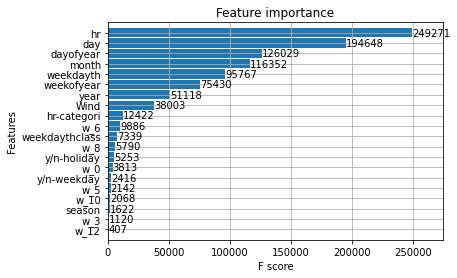

In [12]:
fscores = model.get_fscore()

xgb.plot_importance(model, max_num_features=20, height=0.9)

In [13]:
pred = model.predict(dtest)
result = pd.DataFrame({"id":range(3504), "speed":pred})
result.to_csv("submission17.csv", index=False)

ValueError: feature_names mismatch: ['year', 'month', 'day', 'hr', 'weekdayth', 'weekofyear', 'season', 'dayofyear', 'y/n-weekday', 'hr-categori', 'y/n-holiday', 'Wind', 'weekdaythclass', 'w_0', 'w_2', 'w_3', 'w_5', 'w_6', 'w_7', 'w_8', 'w_10', 'w_12', 'w_14', 'w_16'] ['year', 'month', 'day', 'hr', 'weekdayth', 'weekofyear', 'season', 'dayofyear', 'y/n-weekday', 'hr-categori', 'y/n-holiday', 'Wind', 'weekdaythclass', 'w_0', 'w_3', 'w_5', 'w_6', 'w_7', 'w_8', 'w_10', 'w_16']
expected w_14, w_2, w_12 in input data